# Build dataset from all market data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import warnings
from IPython.display import Image
import seaborn as sns

In [2]:
# import pyomo.environ as pyo
# from pyomo.util.model_size import build_model_size_report

import numpy as np
import pandas as pd

def import_data():

    date_parser = pd.to_datetime
    combined_market_data = pd.read_csv('../build_dataset/combined_market_data.csv', index_col=0, parse_dates=True, date_parser=date_parser)
    # When debugging:
    # combined_market_data = pd.read_csv('nseemann-msc-BESS/30_src/build_dataset/combined_market_data.csv', index_col=0, parse_dates=True, date_parser=date_parser)

    ################## DA and ID data ##################
    IP = combined_market_data['IPindex_netztransparenz_15min_pE']
    IP = IP[IP.first_valid_index():IP.last_valid_index()] #Crop nas
    IP = IP.fillna(IP.shift(96, freq='15min'))  # Fillna from 24h before


    DA = combined_market_data['DADELU_ENTSOE_60min_pE'] 
    DA = DA[DA.first_valid_index():DA.last_valid_index()] #Crop nas
    DA = DA.fillna(DA.shift(24, freq='h')).asfreq('1h') #Fillna from 24h before


    ################## aFRR data ##################
    aFRR_p = combined_market_data[['aFRRpos_SMARD_15min_pP','aFRRneg_SMARD_15min_pP']]
    aFRR_p = aFRR_p[aFRR_p.apply(lambda col: col.first_valid_index()).max(): aFRR_p.apply(lambda col: col.last_valid_index()).min()]
    aFRR_p = aFRR_p.fillna(aFRR_p.shift(6, freq='4h')).resample('4h').sum()  #Fillna from 24h before


    ################## FCR data ##################

    FCR_p = combined_market_data['FCR_regelleistung_4h_pP']
    FCR_p = FCR_p[FCR_p.first_valid_index():FCR_p.last_valid_index()]
    FCR_p = FCR_p.fillna(FCR_p.shift(6, freq='4h')).resample('4h').sum()


    ################## Align the start and end of the datasets ##################
    start = max(DA.first_valid_index(), IP.first_valid_index(), aFRR_p.apply(lambda col: col.first_valid_index()).max(), FCR_p.first_valid_index())
    end = min(DA.last_valid_index(), IP.last_valid_index(), aFRR_p.apply(lambda col: col.last_valid_index()).min(), FCR_p.last_valid_index())

    # print(start,end)

    IP = IP[start:end][:-1]#.dropna()
    DA = DA[start:end][:-1]#.dropna()
    aFRR_p = aFRR_p[start:end][:-1]#.dropna()

    ################## CHECKS ##################

    # # Check both indexes are continuous (should be 1 for first index)
    # print(sum(DA.index.diff() != pd.Timedelta('1h')))
    # print(sum(IP.index.diff() != pd.Timedelta('15min')))
    # print(sum(DA.index.diff() != pd.Timedelta('1h')))
    # print(sum(aFRR_p.index.diff() != pd.Timedelta('4h')))

    # # Check all indexes match when IP is resampled to 1h (should be 0)
    # print((DA.index != IP.asfreq('1h').index).sum()) 

    # # Check all indexes match when DA is resampled to 4h (should be 0)
    # print((aFRR_p.index != DA.asfreq('4h').index).sum()) 

    # print(len(aFRR_p.index))
    # print(len(DA.index)/4)
    # print(len(IP.index)/16)

    return DA, IP, aFRR_p, FCR_p



In [3]:
DA_p, IP_p, aFRR_p, PCR_p = import_data()

/var/folders/28/cmh8kslx4f9gr_zckx5qp_sw0000gn/T/ipykernel_31879/2955391328.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  combined_market_data = pd.read_csv('../build_dataset/combined_market_data.csv', index_col=0, parse_dates=True, date_parser=date_parser)


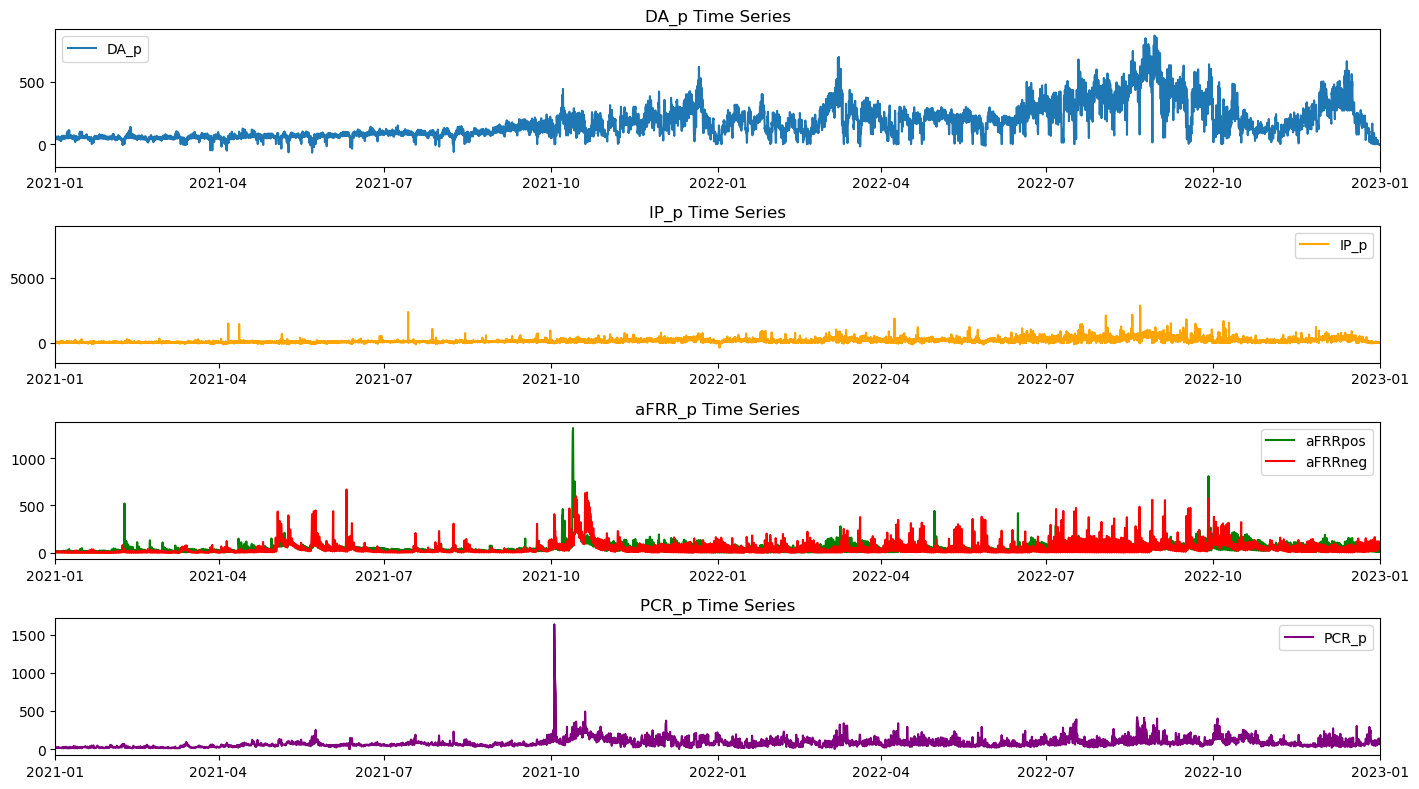

             DA_p      IP_p   aFRRpos   aFRRneg     PCR_p
DA_p     1.000000  0.837001  0.280365 -0.029560  0.202691
IP_p     0.837001  1.000000  0.237327 -0.022705  0.168654
aFRRpos  0.280365  0.237327  1.000000  0.407725  0.199117
aFRRneg -0.029560 -0.022705  0.407725  1.000000  0.463808
PCR_p    0.202691  0.168654  0.199117  0.463808  1.000000


/var/folders/28/cmh8kslx4f9gr_zckx5qp_sw0000gn/T/ipykernel_31879/1630945392.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_combined.fillna(method='ffill', inplace=True)


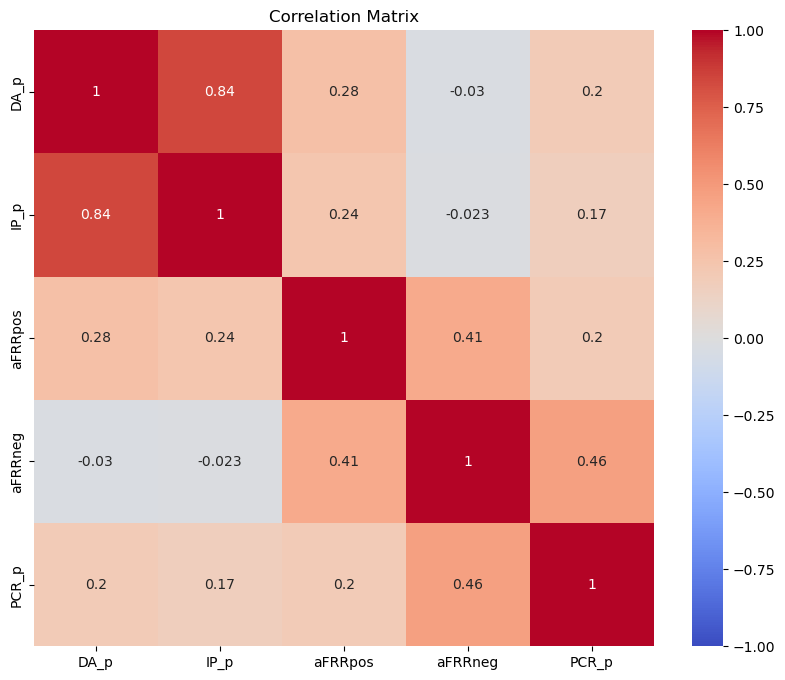

In [4]:
# Plotting the time series data
plt.figure(figsize=(14, 8))

plt.subplot(4, 1, 1)
plt.plot(DA_p, label='DA_p')
plt.title('DA_p Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(IP_p, label='IP_p', color='orange')
plt.title('IP_p Time Series')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(aFRR_p['aFRRpos_SMARD_15min_pP'], label='aFRRpos', color='green')
plt.plot(aFRR_p['aFRRneg_SMARD_15min_pP'], label='aFRRneg', color='red')
plt.title('aFRR_p Time Series')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(PCR_p, label='PCR_p', color='purple')
plt.title('PCR_p Time Series')
plt.legend()

plt.tight_layout()
for ax in plt.gcf().axes:
    ax.set_xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))
plt.show()

# Correlation matrix
data_combined = pd.DataFrame({
    'DA_p': DA_p,
    'IP_p': IP_p,#.asfreq('1h'),
    'aFRRpos': aFRR_p['aFRRpos_SMARD_15min_pP'],#.asfreq('1h'),
    'aFRRneg': aFRR_p['aFRRneg_SMARD_15min_pP'],#.asfreq('1h'),
    'PCR_p': PCR_p#.asfreq('1h')
})

data_combined.fillna(method='ffill', inplace=True)
correlation_matrix = data_combined.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()



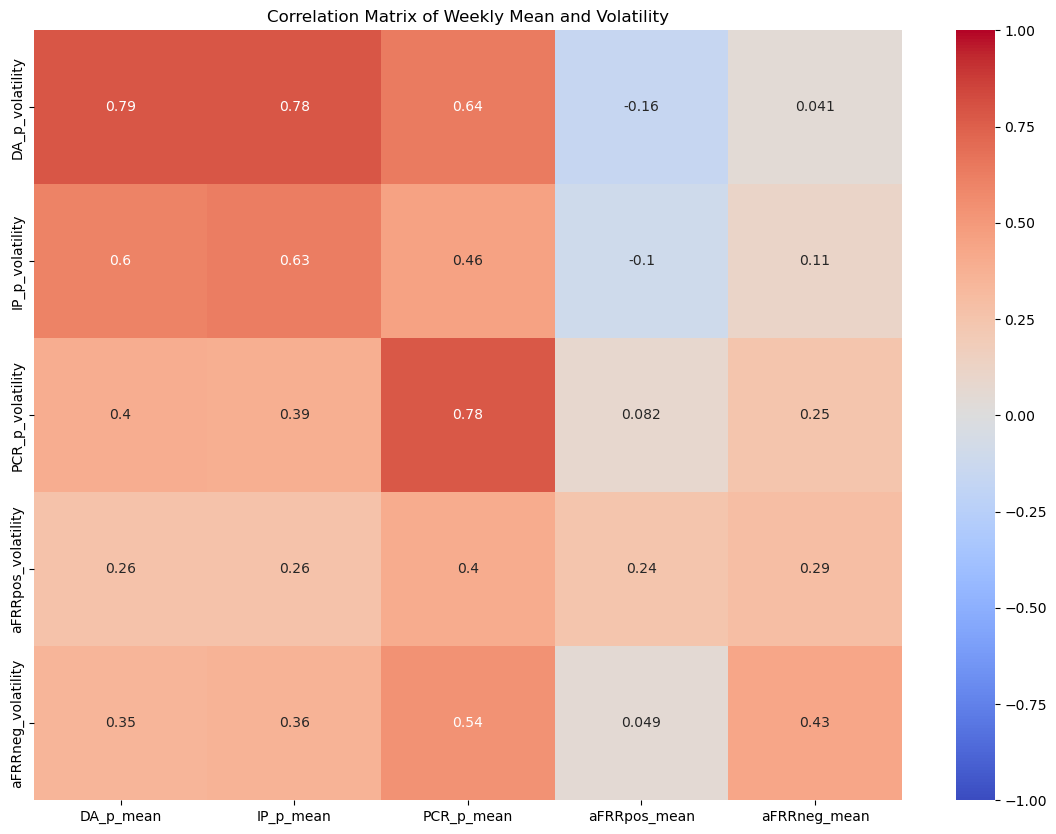

In [5]:
# Resample the data to weekly frequency and calculate the mean
weekly_mean = data_combined.resample('W').mean()

# Calculate the weekly volatility (standard deviation)
weekly_volatility = data_combined.resample('W').std()

# Combine the weekly mean and volatility into a single DataFrame
weekly_data = pd.concat([weekly_mean.add_suffix('_mean'), weekly_volatility.add_suffix('_volatility')], axis=1)

# Compute the correlation matrix
weekly_correlation_matrix = weekly_data.corr()[['DA_p_mean','IP_p_mean','PCR_p_mean','aFRRpos_mean','aFRRneg_mean']].loc[['DA_p_volatility','IP_p_volatility','PCR_p_volatility','aFRRpos_volatility','aFRRneg_volatility']]

# Plotting the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(weekly_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Weekly Mean and Volatility')
plt.show()

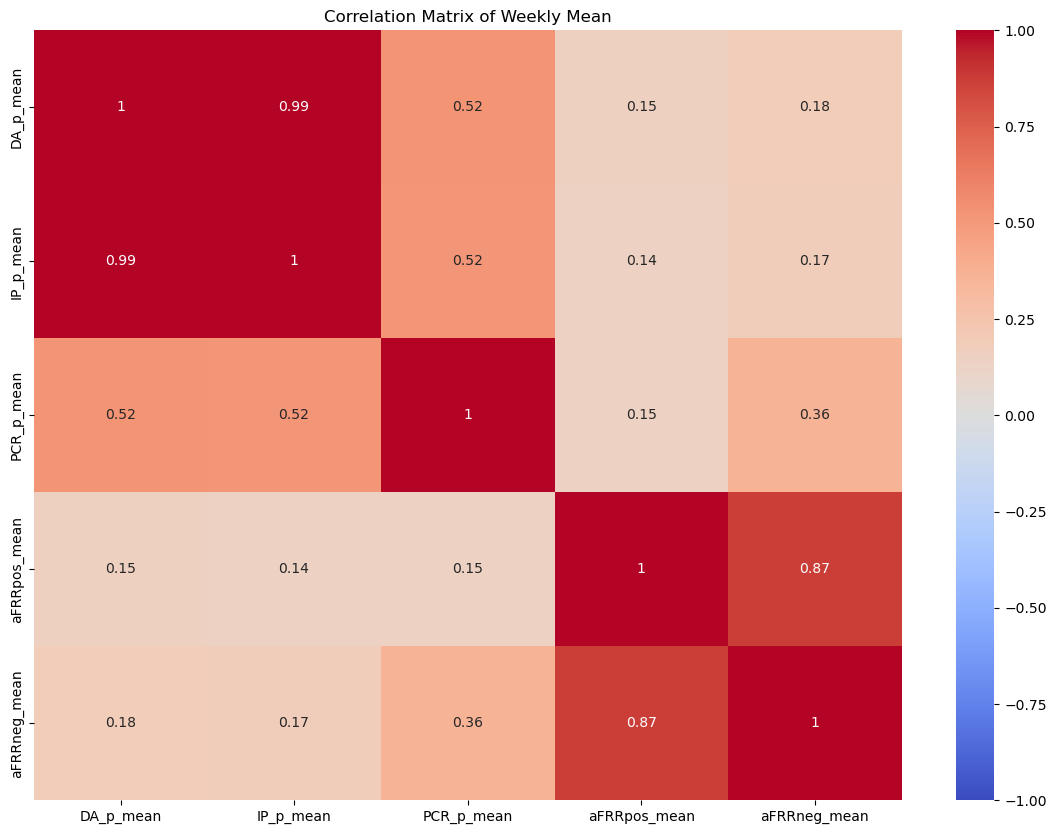

In [6]:
# Resample the data to weekly frequency and calculate the mean
weekly_mean = data_combined.resample('W').mean()

# Calculate the weekly volatility (standard deviation)
weekly_volatility = data_combined.resample('W').std()

# Combine the weekly mean and volatility into a single DataFrame
weekly_data = pd.concat([weekly_mean.add_suffix('_mean'), weekly_volatility.add_suffix('_volatility')], axis=1)

# Compute the correlation matrix
weekly_correlation_matrix = weekly_data.corr()[['DA_p_mean','IP_p_mean','PCR_p_mean','aFRRpos_mean','aFRRneg_mean']].loc[['DA_p_mean','IP_p_mean','PCR_p_mean','aFRRpos_mean','aFRRneg_mean',]]

# Plotting the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(weekly_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Weekly Mean')
plt.show()

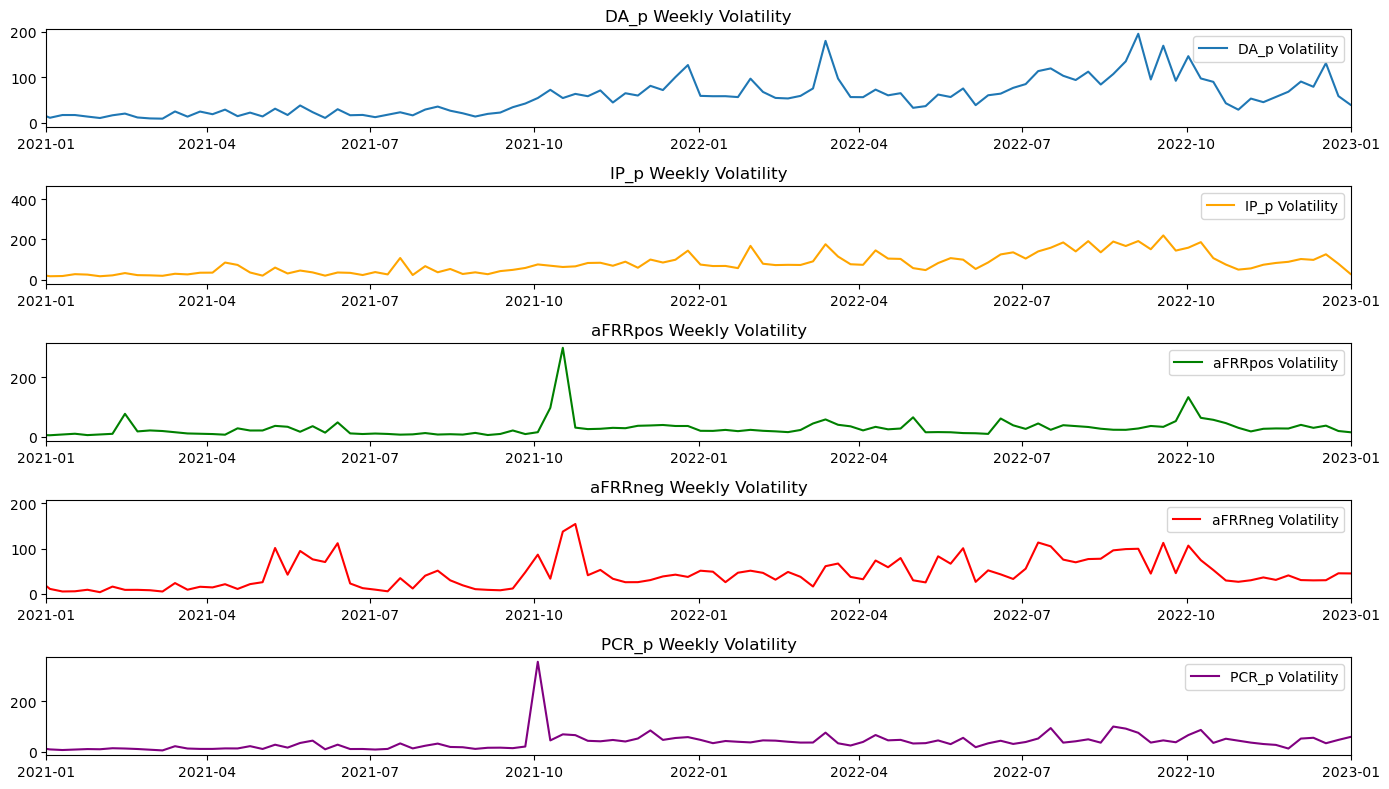

In [17]:
# Plotting the weekly volatility
plt.figure(figsize=(14, 8))

plt.subplot(5, 1, 1)
plt.plot(weekly_volatility['DA_p'], label='DA_p Volatility')
plt.title('DA_p Weekly Volatility')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.subplot(5, 1, 2)
plt.plot(weekly_volatility['IP_p'], label='IP_p Volatility', color='orange')
plt.title('IP_p Weekly Volatility')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.subplot(5, 1, 3)
plt.plot(weekly_volatility['aFRRpos'], label='aFRRpos Volatility', color='green')
plt.title('aFRRpos Weekly Volatility')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.subplot(5, 1, 4)
plt.plot(weekly_volatility['aFRRneg'], label='aFRRneg Volatility', color='red')
plt.title('aFRRneg Weekly Volatility')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.subplot(5, 1, 5)
plt.plot(weekly_volatility['PCR_p'], label='PCR_p Volatility', color='purple')
plt.title('PCR_p Weekly Volatility')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.tight_layout()
plt.show()

In [ ]:
# Plotting the weekly mean prices
plt.figure(figsize=(14, 8))

plt.subplot(5, 1, 1)
plt.plot(weekly_mean['DA_p'], label='DA_p Mean')
plt.title('DA_p Weekly Mean')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.subplot(5, 1, 2)
plt.plot(weekly_mean['IP_p'], label='IP_p Mean', color='orange')
plt.title('IP_p Weekly Mean')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.subplot(5, 1, 3)
plt.plot(weekly_mean['aFRRpos'], label='aFRRpos Mean', color='green')
plt.title('aFRRpos Weekly Mean')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.subplot(5, 1, 4)
plt.plot(weekly_mean['aFRRneg'], label='aFRRneg Mean', color='red')
plt.title('aFRRneg Weekly Mean')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.subplot(5, 1, 5)
plt.plot(weekly_mean['PCR_p'], label='PCR_p Mean', color='purple')
plt.title('PCR_p Weekly Mean')
plt.legend()
plt.xlim(pd.to_datetime('2021-01-01'), pd.to_datetime('2023-01-01'))

plt.tight_layout()
plt.show()